In [1]:
from train_models_debug import section1, section2, single_model

Num GPUs Available:  1


In [2]:
import random
def reduce_model_size(conv_layers, dense_layers, factor=0.8, rand_factor=None):
    if rand_factor:
        conv_layers = [max(1, int(layer * random.uniform(rand_factor[0], rand_factor[1]))) for layer in conv_layers if layer > 1]
        dense_layers = [max(1, int(layer * random.uniform(rand_factor[0], rand_factor[1]))) for layer in dense_layers if layer > 1]
        
    else:
        conv_layers = [max(1, int(layer * factor)) for layer in conv_layers if layer > 1]
        dense_layers = [max(1, int(layer * factor)) for layer in dense_layers if layer > 1]

    conv_layers = [layer for layer in conv_layers if layer >= 4]
    dense_layers = [layer for layer in dense_layers if layer >= 8]

    return conv_layers, dense_layers

In [3]:
import matplotlib.pyplot as plt

def plot_results(trainable_params_list, training_time_list, iteration_list, figsize=(15, 5)):
    # Plot the first graph: Trainable parameters vs. Training time
    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)  # Plot in the first subplot (1 row, 3 columns)
    plt.plot(trainable_params_list[::-1], training_time_list, marker='o', linestyle='-', color='b')
    plt.xlabel('Trainable Parameters')
    plt.ylabel('Training Time (seconds)')
    plt.title('Trainable Parameters vs Training Time')

    # Plot the second graph: Iteration vs. Training time
    plt.subplot(1, 3, 2)  # Plot in the second subplot
    plt.plot(iteration_list, training_time_list, marker='x', linestyle='-', color='r')
    plt.xlabel('Iteration')
    plt.ylabel('Training Time (seconds)')
    plt.title('Iteration vs Training Time')

    # Plot the third graph: Trainable Parameters vs Iteration
    plt.subplot(1, 3, 3)  # Plot in the third subplot
    plt.plot(iteration_list, trainable_params_list, marker='^', linestyle='-', color='g')
    plt.xlabel('Iteration')
    plt.ylabel('Trainable Parameters')
    plt.title('Trainable Parameters vs Iteration')

    # Show all plots
    plt.tight_layout()
    plt.show()


In [4]:
from tensorflow.keras.backend import clear_session

def optimize(model, conv_layers, dense_layers, target, max_iter=10, layer_factor=0.8, random_factor=None, max_failed_trains=2):
    trainable_params_list = []
    training_time_list = []
    iteration_list = []

    best_conv = conv_layers
    best_dense = dense_layers
    iter_num = 0

    failed_trains = 0

    for i in range(max_iter):
        print(f"Iteration: {i}/{max_iter}")
        print(f"Training model with: {conv_layers}, {dense_layers}")

        #model = sect1()
        trainable_params = model.initialise_data_and_model(conv_layers=conv_layers, dense_layers=dense_layers)
        params = {'epochs': 80,
                  'tensorboard': False, 
                  'cp_callback': False,
                  'weights': None,
                  'stop_at': target,
                  'save_final': True,
                  'weight_string': f'weights_{i}'
                 }

        try:
            reached_target, training_time = model.train(params)

            print(f"Training time: {training_time}s")
        
            trainable_params_list.append(trainable_params)
            training_time_list.append(training_time)
            iteration_list.append(i)

            model.plot()
            #model.eval_random()

            # If the target is not reached, break the loop
            if not reached_target:
                failed_trains += 1
                print(f"Target value not reached, attempt: {failed_trains}")
                if failed_trains >= max_failed_trains:
                    print("Target value not reached, done optimizing")
                    break
            else:
                failed_trains = 0

            if training_time == min(training_time_list):                
                best_conv = conv_layers
                best_dense = dense_layers
                iter_num = i
             
            # Reduce the model size for the next iteration
            conv_layers, dense_layers = reduce_model_size(conv_layers, dense_layers, factor=layer_factor, rand_factor=random_factor)

        except Exception as e:
            print(f"Error during training on iteration {i}: {str(e)}")
            break  # Exit the loop if training fails due to an error

        clear_session()

    plot_results(trainable_params_list, training_time_list, iteration_list)
    return best_conv, best_dense, iter_num


Iteration: 0/10
Training model with: [64, 80, 150, 48], [50, 512, 220]


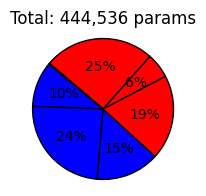

Epoch 24/80 - loss: 37.3886 - mean_absolute_error: 4.5462 - val_loss: 15.4671 - val_mean_absolute_error: 2.91975749
Target MAE of 3 reached! Stopping training.

Training time: 45.7s
The history has the following data:  dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


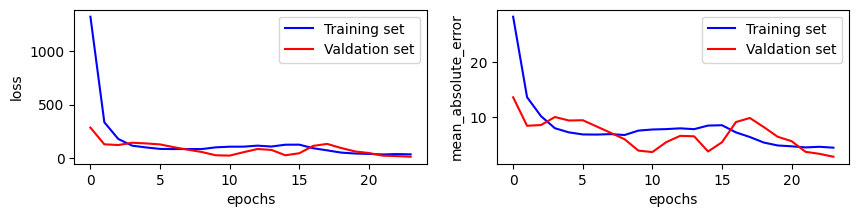

Iteration: 1/10
Training model with: [61, 74, 151, 35], [42, 363, 170]


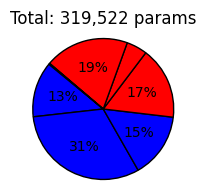

Epoch 28/80 - loss: 39.0917 - mean_absolute_error: 4.7326 - val_loss: 16.1194 - val_mean_absolute_error: 2.93426330
Target MAE of 3 reached! Stopping training.

Training time: 48.9s
The history has the following data:  dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


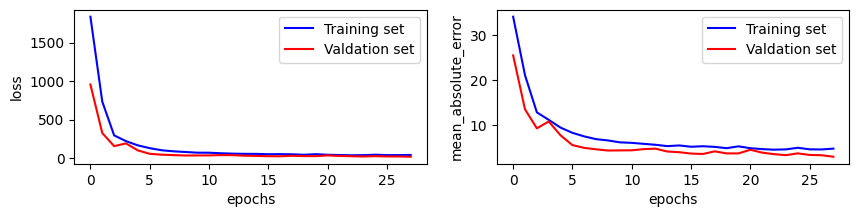

Iteration: 2/10
Training model with: [54, 57, 136, 34], [29, 356, 160]


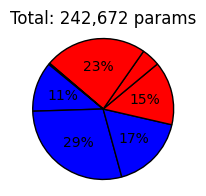

Epoch 42/80 - loss: 41.8568 - mean_absolute_error: 4.8127 - val_loss: 77.7185 - val_mean_absolute_error: 7.23800631

In [ ]:
conv_layers = [64,80,150,48]
dense_layers = [50,512,220]
target = 3
model = section1()
best_conv, best_dense, iter_num = optimize(model=model, conv_layers=conv_layers, dense_layers=dense_layers, target=target, max_iter=10, random_factor=(0.7, 1.05), max_failed_trains=2)

In [ ]:
print(best_conv, best_dense, iter_num)

In [ ]:
weights_folder = '../checkpoints_sect1/'
eval_model = section1()
eval_model.initialise_data_and_model(conv_layers=best_conv, dense_layers=best_dense)
eval_model.model.load_weights(weights_folder + f'modelweights_{iter_num}.weights.h5')

In [ ]:
eval_model.eval_random()